# Scalability analysis (strong scaling)

This notebook analyzes MPI scalability for both time integrators using the CSV produced by the scalability script:

- Input: `scalability-results.csv`
- Metrics: wall time, speedup, efficiency

Speedup and efficiency are computed **per configuration** `(scheme, Nel, R, Dt, T)` using the `nprocs=1` timing as baseline.

Crank-Nicolson for the Theta method. beta=0.25, gamma=0.5 for Newmark.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [2]:
csv_path = Path('scalability-results-ghi.csv')
df = pd.read_csv(csv_path)

# Basic cleanup / typing
df = df.copy()
df['nprocs'] = pd.to_numeric(df['nprocs'], errors='coerce')
df['Nel'] = pd.to_numeric(df['Nel'], errors='coerce')
df['R'] = pd.to_numeric(df['R'], errors='coerce')
df['Dt'] = pd.to_numeric(df['Dt'], errors='coerce')
df['T'] = pd.to_numeric(df['T'], errors='coerce')
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')
df['returncode'] = pd.to_numeric(df['returncode'], errors='coerce')

# Keep only successful runs with valid timing
df = df[(df['returncode'] == 0) & df['seconds'].notna() & (df['seconds'] > 0)].copy()

# If duplicates exist, keep the minimum time (best run) for the same setting
dedup_keys = ['scheme', 'binary', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']
df = df.sort_values('seconds').drop_duplicates(subset=dedup_keys, keep='first')

df.head()

,scheme,binary,nprocs,Nel,R,Dt,T,Theta,Beta,Gamma,returncode,seconds
6,newmark,../build/main-newmark,4,160,1,0.005,1.0,NaN,0.25,0.5,0,10.107177
3,theta,../build/main-theta,4,160,1,0.005,1.0,0.5,NaN,NaN,0,12.028936
5,newmark,../build/main-newmark,2,160,1,0.005,1.0,NaN,0.25,0.5,0,19.396538
2,theta,../build/main-theta,2,160,1,0.005,1.0,0.5,NaN,NaN,0,23.704994
4,newmark,../build/main-newmark,1,160,1,0.005,1.0,NaN,0.25,0.5,0,35.176269


In [3]:
# Compute strong-scaling speedup/efficiency per configuration (scheme + discretization + final time)
group_keys = ['scheme', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']

# Baseline timings (nprocs == 1) per configuration
base = (
    df[df['nprocs'] == 1][group_keys + ['seconds']]
    .rename(columns={'seconds': 't_base'})
    .groupby(group_keys, dropna=False, as_index=False)['t_base'].min()
)

# Join baseline back and compute metrics (vectorized, no GroupBy.apply => no warning)
dfm = df.merge(base, on=group_keys, how='left')
dfm = dfm[dfm['t_base'].notna()].copy()
dfm['speedup'] = dfm['t_base'] / dfm['seconds']
dfm['efficiency'] = dfm['speedup'] / dfm['nprocs']

dfm[['scheme', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'seconds', 'speedup', 'efficiency']].sort_values(['scheme','Nel','Dt','T','nprocs']).head(20)

,scheme,nprocs,Nel,R,Dt,T,seconds,speedup,efficiency
4,newmark,1,160,1,0.005,1.0,35.176269,1.000000,1.000000
2,newmark,2,160,1,0.005,1.0,19.396538,1.813533,0.906767
0,newmark,4,160,1,0.005,1.0,10.107177,3.480326,0.870081
5,theta,1,160,1,0.005,1.0,41.002967,1.000000,1.000000
3,theta,2,160,1,0.005,1.0,23.704994,1.729719,0.864859
1,theta,4,160,1,0.005,1.0,12.028936,3.408694,0.852174
6,theta,1,160,1,0.005,10.0,406.148908,1.000000,1.000000


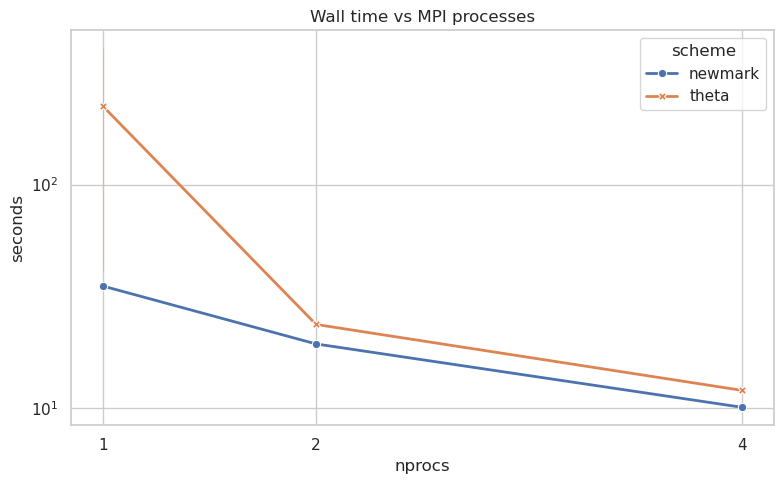

In [4]:
# Runtime vs nprocs (one curve per scheme per (Nel,Dt,T) setting if multiple exist)
plot_keys = ['scheme', 'Nel', 'R', 'Dt', 'T']
df_plot = dfm.copy()

# Build a label for the discretization/time config
df_plot['case'] = (
    'Nel=' + df_plot['Nel'].astype(int).astype(str)
    + ', R=' + df_plot['R'].astype(int).astype(str)
    + ', Dt=' + df_plot['Dt'].astype(str)
    + ', T=' + df_plot['T'].astype(str)
)

plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=df_plot, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2
)
ax.set_title('Wall time vs MPI processes')
ax.set_xlabel('nprocs')
ax.set_ylabel('seconds')
ax.set_yscale('log')
ax.set_xticks(sorted(df_plot['nprocs'].unique()))
plt.tight_layout()

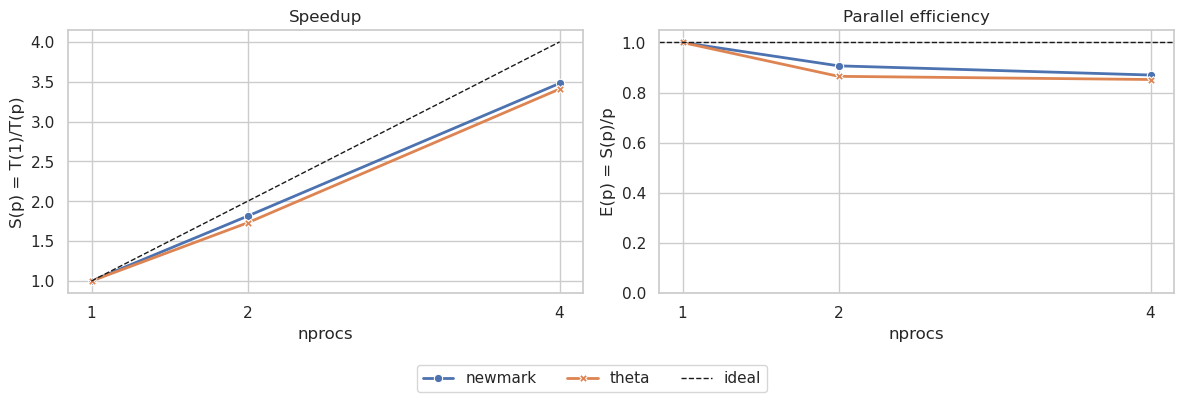

In [5]:
# Speedup and efficiency vs nprocs
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=dfm, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0]
)
axes[0].plot([1, dfm['nprocs'].max()], [1, dfm['nprocs'].max()], color='k', linewidth=1, linestyle='--', label='ideal')
axes[0].set_title('Speedup')
axes[0].set_xlabel('nprocs')
axes[0].set_ylabel('S(p) = T(1)/T(p)')
axes[0].set_xticks(sorted(dfm['nprocs'].unique()))

sns.lineplot(
    data=dfm, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1]
)
axes[1].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Parallel efficiency')
axes[1].set_xlabel('nprocs')
axes[1].set_ylabel('E(p) = S(p)/p')
axes[1].set_xticks(sorted(dfm['nprocs'].unique()))
axes[1].set_ylim(0, max(1.05, float(dfm['efficiency'].max()) * 1.05))

# De-duplicate legends (single legend outside)
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])